## Using Long Short Term Memory (LSTM) neural networks for cryptocurrency price movement prediction
* Forget gate: decides what information to throw away and what past information to remember
* Update/input gate: what new information is added and how much information is added
* Output gate: conditionally decided what to output from Memory 
<br> *Source: https://medium.com/@ahmetozlu93/long-short-term-memory-lstm-networks-in-a-nutshell-363cd470ccac*  
 
    


*Source code: https://www.youtube.com/watch?v=H6du_pfuznE&ab_channel=KrishNaik*

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read the file in from device
df = pd.read_csv('BTC_INR.csv')

In [3]:
# Change the index to the date
df = df.set_index(pd.DatetimeIndex(df['Date'].values)) 
df.index.name = 'Date'
df.drop(columns=['Date'], inplace=True)

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-24,531125.5625,534905.8750,528807.6250,532109.6250,532109.6250,1.155234e+12
2019-10-25,531911.8125,615708.6875,529882.0625,613524.0625,613524.0625,2.033467e+12
2019-10-26,614011.1875,709940.3750,613660.1875,654913.8125,654913.8125,3.152115e+12
2019-10-27,654682.5000,690656.6250,645532.4375,676643.4375,676643.4375,2.308897e+12
2019-10-28,677591.8125,693664.0625,654827.1250,654827.1250,654827.1250,2.189437e+12


In [6]:
# Check of null values in the data
filt = df['Open'].isnull()
df[filt]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-04,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# There is 1 day of missing values. Using linear interpolate to fill that value
df = df.interpolate()

In [10]:
# Missing values filled in using interpolate()
df[filt]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-04,834176.75,872190.40625,831134.90625,861993.21875,861993.21875,1.674818e+12


In [15]:
df1 = df['Close']

## Visualise the data

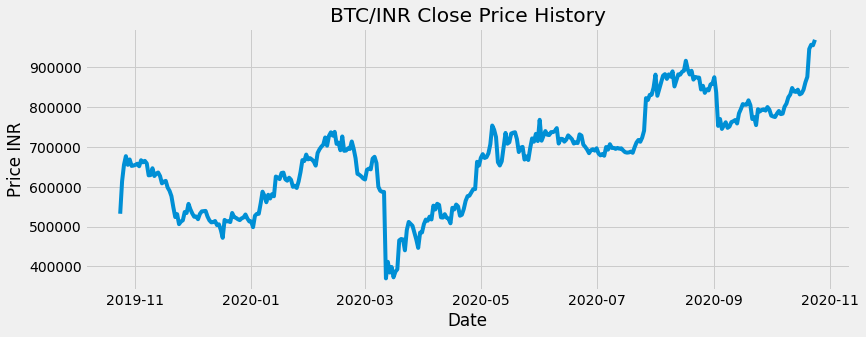

In [17]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(df1, label='Close')
plt.title('BTC/INR Close Price History')
plt.xlabel('Date')
plt.ylabel('Price INR')
plt.show()

In [21]:
# LSTMs are sensitive to scale of data
scaler = MinMaxScaler(feature_range=(0,1)) # The values we need to scale is between 0 and 1
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [594]:
# Splitting data into train-test split
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [595]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step -1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[1+time_step,0])
    return np.array(dataX), np.array(dataY)

In [683]:
time_step = 90
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [684]:
X_train.shape

(147, 90)

In [685]:
# LSTMs need to reshaped into 3D (samples, time_step, features) -> add 1 to the existing shape 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [686]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [687]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [688]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 90, 50)            10400     
_________________________________________________________________
lstm_22 (LSTM)               (None, 90, 50)            20200     
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [689]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=0)

In [690]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [691]:
# Transform back from MinMax Scaler
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [692]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

599656.1634183621

In [693]:
math.sqrt(mean_squared_error(y_test, test_predict))

598496.8467540113

In [694]:
# Length of the test data
len(test_data)

129

In [695]:
len(test_data)-time_step

39

In [696]:
def get_prediction():
    x_input = test_data[:time_step].reshape(1,-1) #Taking the first time_step number of values
    x_input_list = x_input[0].tolist() # Use this to draw the last time_step number of values

    i=0
    while i < (len(test_data)-time_step):
        x_input = np.array(x_input_list[-time_step:]).astype('float32') # Taking the last time_step number of values
        x_input = x_input.reshape((1, time_step,1))
        yHat = model.predict(x_input, verbose=0)
        x_input_list.append(yHat.item(0))
        i+=1

    return scaler.inverse_transform(np.array(x_input_list).reshape(-1, 1))     

In [697]:
final_pred = get_prediction()

In [712]:
final_pred.flatten().round(2)

array([719070.69, 708232.31, 711612.  , 709423.62, 731276.81, 728123.  ,
       705452.88, 699862.62, 692973.12, 684084.81, 691438.19, 694011.06,
       690443.94, 696325.69, 683252.19, 678634.87, 682009.19, 677638.  ,
       699483.06, 693029.31, 706560.62, 697124.25, 697383.12, 694832.44,
       697210.  , 695231.12, 696265.94, 690849.56, 686567.75, 685416.75,
       685989.56, 687995.06, 685029.5 , 698836.94, 710687.81, 717179.62,
       712641.44, 723119.38, 740510.88, 822141.94, 817375.88, 830489.31,
       830777.69, 848466.19, 881145.13, 828115.31, 845338.06, 861993.22,
       878648.38, 882346.75, 870409.25, 881853.25, 875972.81, 889387.31,
       851413.5 , 866195.56, 881735.69, 880955.25, 888203.31, 890807.19,
       915978.56, 894266.  , 881539.69, 890749.  , 868617.06, 875311.  ,
       873954.31, 873601.44, 843803.69, 853137.94, 835375.12, 844085.69,
       841479.81, 856445.44, 857813.75, 874639.19, 836109.38, 752531.38,
       769950.44, 744882.12, 753452.62, 761595.19, 

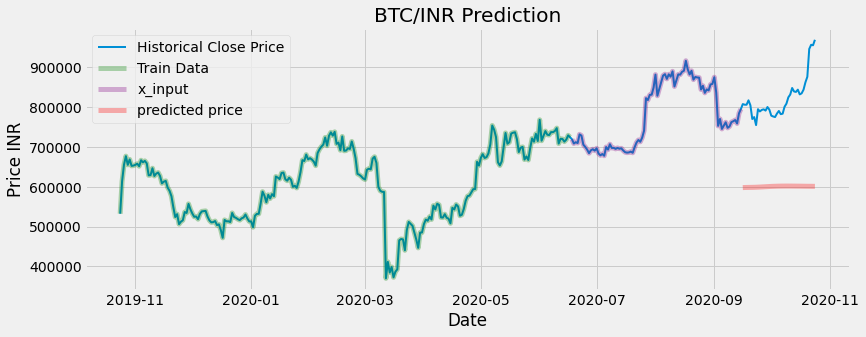

In [742]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(df.index, scaler.inverse_transform(df1), label='Historical Close Price', alpha=1, linewidth=2) 
plt.plot(df.index[0:len(scaler.inverse_transform(train_data))], scaler.inverse_transform(train_data), label='Train Data', alpha=0.3, color='green', linewidth=5)
plt.plot(df.index[training_size:len(df1)][:time_step], scaler.inverse_transform(test_data[:time_step]), label='x_input', alpha=0.3, color='purple', linewidth=5)
plt.plot(df.index[training_size:len(df1)][time_step:], final_pred.flatten()[time_step:], label='predicted price', alpha=0.3, color='red', linewidth=5)
plt.title('BTC/INR Prediction')
plt.xlabel('Date')
plt.ylabel('Price INR')
plt.legend(loc='upper left')
plt.show()